In [3]:
import os
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

from sklearn.cluster import KMeans
import datetime as dt

load_dotenv()

True

In [4]:
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_user = os.getenv('DB_USER')
db_pass = os.getenv('DB_PASS')
db_name = os.getenv('DB_NAME')

connection = f'postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}'
engine = create_engine(connection)

In [5]:
table = 'customers'
query = f"""
SELECT event_time, user_id
FROM {table}
WHERE event_type = 'purchase';
"""

In [6]:
# Ejecutar la consulta y cargar los datos en un DataFrame
try:
    data = pd.read_sql(query, engine)
except Exception as e:
    print(f"Error al conectar o consultar la base de datos: {e}")

# Mostrar las primeras filas del DataFrame
data.head()

,event_time,user_id
0,2022-12-28 13:00:31,441439697
1,2022-12-28 13:00:31,441439697
2,2022-12-28 13:00:31,441439697
3,2022-12-28 13:00:31,441439697
4,2022-12-28 13:00:31,441439697


In [7]:
# fecha de referencia, asumiendo que el último día de compras es el día más reciente en los datos
reference_date = data['event_time'].max()

# Crear el DataFrame `rfm` para recencia (días desde la última compra), frecuencia y otros valores
rfm = data.groupby('user_id').agg({
    'event_time': lambda x: (reference_date - x.max()).days,  # Recencia: días desde la última compra
    'user_id': 'count'  # Frecuencia: número de compras
}).rename(columns={'event_time': 'Recency', 'user_id': 'Frequency'})

print(rfm)

           Recency  Frequency
user_id                      
9794320         67          4
10079204        86          2
10280338        19         17
12055855        42          4
12936739        14          2
...            ...        ...
608807757        0          3
608809325        0          1
608809552        0          4
608812129        0          8
608817151        0          3

[92651 rows x 2 columns]


In [18]:
# Normalizar los datos para el clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Usar KMeans para segmentación
kmeans = KMeans(n_clusters=4, random_state=42)  # Asumimos 4 clusters
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

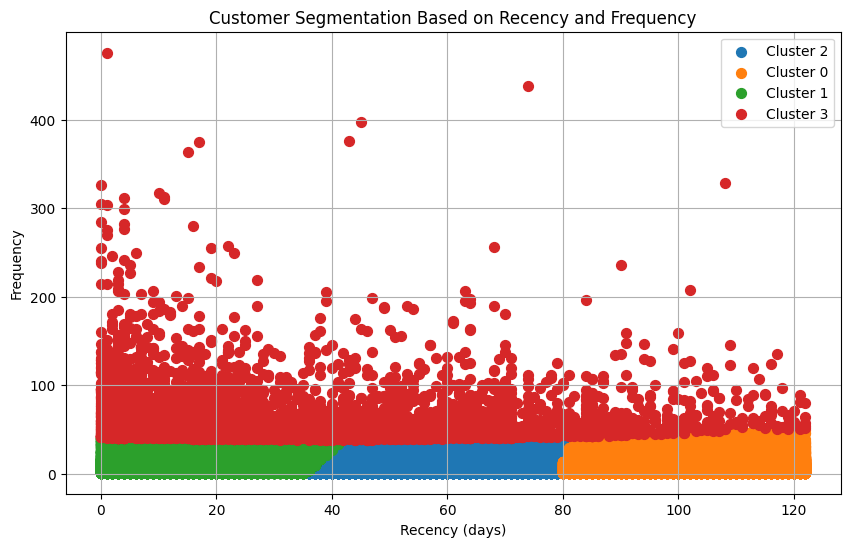

In [19]:
plt.figure(figsize=(10, 6))

# Crear un scatter plot
for cluster_id in rfm['Cluster'].unique():
    clustered_data = rfm[rfm['Cluster'] == cluster_id]
    plt.scatter(clustered_data['Recency'], clustered_data['Frequency'], label=f'Cluster {cluster_id}', s=50)

# Etiquetas y título
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.title('Customer Segmentation Based on Recency and Frequency')
plt.legend()
plt.grid(True)
plt.show()


                 event_time    user_id
0       2022-12-28 13:00:31  441439697
1       2022-12-28 13:00:31  441439697
2       2022-12-28 13:00:31  441439697
3       2022-12-28 13:00:31  441439697
4       2022-12-28 13:00:31  441439697
...                     ...        ...
1044126 2022-12-28 12:56:23  514262399
1044127 2022-12-28 12:56:23  514262399
1044128 2022-12-28 12:56:23  514262399
1044129 2022-12-28 12:56:23  514262399
1044130 2022-12-28 12:56:23  514262399

[1044131 rows x 2 columns]


In [10]:
# Definir los grupos de clientes
conditions = [
    (rfm['Recency'] <= 7),                          # Recencia menor o igual a 7 días => 'Loyal Customer'
    (rfm['Recency'] > 7) & (rfm['Recency'] <= 30),  # Recencia entre 7 y 30 días => 'New Customer'
    (rfm['Recency'] > 30)                           # Recencia mayor a 30 días => 'Inactive Customer'
]

choices = ['Loyal Customer', 'New Customer', 'Inactive Customer']

rfm['Customer Category'] = pd.Categorical(pd.cut(rfm['Recency'], bins=[-1, 7, 30, float('inf')],
                                                 labels=choices, include_lowest=True))

print(rfm)

           Recency  Frequency  Customer Category
user_id                                         
9794320         67          4  Inactive Customer
10079204        86          2  Inactive Customer
10280338        19         17       New Customer
12055855        42          4  Inactive Customer
12936739        14          2       New Customer
...            ...        ...                ...
608807757        0          3     Loyal Customer
608809325        0          1     Loyal Customer
608809552        0          4     Loyal Customer
608812129        0          8     Loyal Customer
608817151        0          3     Loyal Customer

[92651 rows x 3 columns]


In [9]:
# Contar la cantidad de clientes en cada grupo
category_counts = rfm['Customer Category'].value_counts().reindex(choices).fillna(0)
print(category_counts)

Customer Category
Loyal Customer        9321
New Customer         18898
Inactive Customer    64432
Name: count, dtype: int64


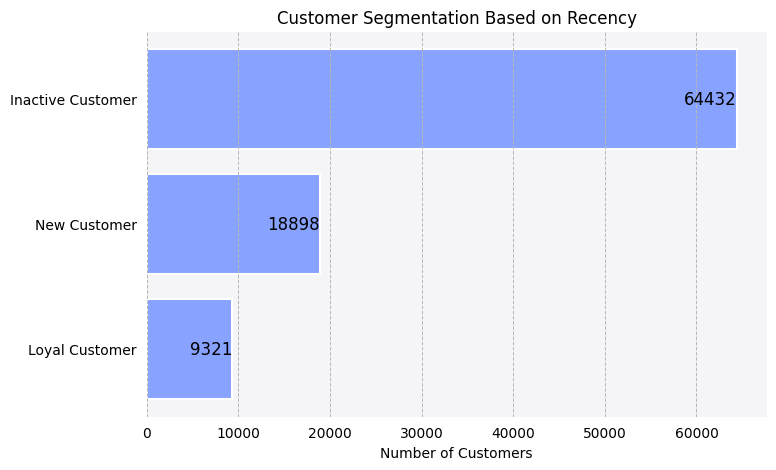

In [11]:
# Crear el gráfico de barras horizontal
plt.figure(figsize=(8, 5))
plt.barh(category_counts.index, category_counts.values, color='#87A2FF', edgecolor='white', linewidth=1.5)

# Añadir etiquetas
for index, value in enumerate(category_counts.values):
    plt.text(value, index, str(int(value)), va='center', ha='right', fontsize=12, color='black')

# Personalización del gráfico
plt.xlabel('Number of Customers')
plt.title('Customer Segmentation Based on Recency')
plt.gca().set_facecolor('#F5F5F7')  # Fondo
plt.grid(axis='x', color='#B7B7B7', linestyle='--', linewidth=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
# Quitar las marcas (ticks) del eje X y Y
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=False, right=False)

# Mostrar el gráfico
plt.show()